### Import libraries

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, losses
from keras.preprocessing import image
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import keras
import os

### Prepare Dataset

In [2]:
def prepare_dataset(path):
    dataset = []
    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            img = image.load_img(path+filename, target_size=(256, 256))
            dataset.append(image.img_to_array(img))
    return np.array(dataset)

In [3]:
def show_data(data, n_imgs=8, title=""):
    plt.figure(figsize=(15, 5))
    for i in range(n_imgs):
        ax = plt.subplot(2,n_imgs,i+1)
        plt.imshow(image.array_to_img(data[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title(title)

In [4]:
traindir = "C:\\Users\\user\\Desktop\\autoencoders\\train\\"
healthy_testdir = "C:\\Users\\user\\Desktop\\autoencoders\\healthy_test\\"
disease_testdir = "C:\\Users\\user\\Desktop\\autoencoders\\disease_test\\"

traindata = prepare_dataset(traindir)
healthy_testdata = prepare_dataset(healthy_testdir)
disease_testdata = prepare_dataset(disease_testdir)

In [5]:
print("Train Data", traindata.shape)
print("Healthy Test Data", healthy_testdata.shape)
print("Disease/Anomaly Test Data", disease_testdata.shape)

Train Data (1600, 256, 256, 3)
Healthy Test Data (30, 256, 256, 3)
Disease/Anomaly Test Data (17, 256, 256, 3)


### Glimpse at the training and test data

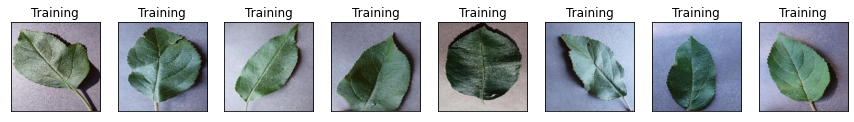

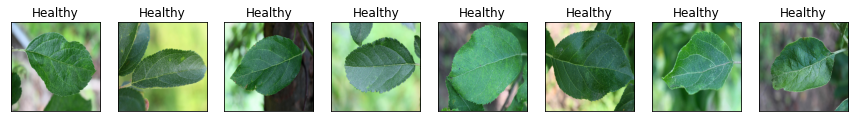

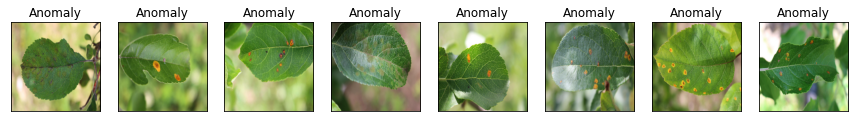

In [6]:
show_data(traindata, title="Training")
show_data(healthy_testdata, title="Healthy")
show_data(disease_testdata, title="Anomaly")

### Autoencoder architecture

In [7]:
from keras import layers
input_layer = Input(shape=(256, 256, 3), name="INPUT")
encoder = layers.GaussianNoise(stddev=0.2)(input_layer)
encoder = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2))(encoder)
encoder = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2))(encoder)
encoder = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)

code_layer = MaxPooling2D((2, 2), name="CODE")(encoder)

decoder = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(code_layer)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2,2))(decoder)
output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(decoder)

In [8]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(loss=losses.MeanSquaredError(), optimizer='adam', metrics=['accuracy'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 256, 256, 3)      0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 8)        0     

### Train the network

In [9]:
history = autoencoder.fit(traindata, traindata,
                epochs=30,
                batch_size=8,
                shuffle=True,
                validation_split = 0.2)

Epoch 1/30
160/160 [==============================] - 37s 229ms/step - loss: 1585.8584 - accuracy: 0.4936 - val_loss: 494.3821 - val_accuracy: 0.7148
Epoch 2/30
160/160 [==============================] - 37s 229ms/step - loss: 429.5603 - accuracy: 0.7202 - val_loss: 381.8253 - val_accuracy: 0.7550
Epoch 3/30
160/160 [==============================] - 37s 229ms/step - loss: 368.2848 - accuracy: 0.7472 - val_loss: 339.6932 - val_accuracy: 0.7700
Epoch 4/30
160/160 [==============================] - 37s 230ms/step - loss: 338.1980 - accuracy: 0.7606 - val_loss: 315.6461 - val_accuracy: 0.7847
Epoch 5/30
160/160 [==============================] - 37s 230ms/step - loss: 319.9815 - accuracy: 0.7876 - val_loss: 300.2711 - val_accuracy: 0.8147
Epoch 6/30
160/160 [==============================] - 37s 230ms/step - loss: 301.4443 - accuracy: 0.8259 - val_loss: 282.0092 - val_accuracy: 0.8537
Epoch 7/30
160/160 [==============================] - 37s 230ms/step - loss: 287.9266 - accuracy: 0.8510 

### Save the model

In [10]:
autoencoder.save("leaf_dataset_anomaly_detection_autoencoder.h5")

### Plot training loss vs validation loss graph

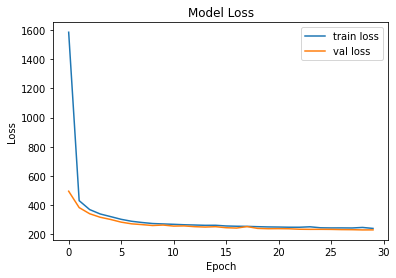

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.show()

### Model Prediction and Reconstruction

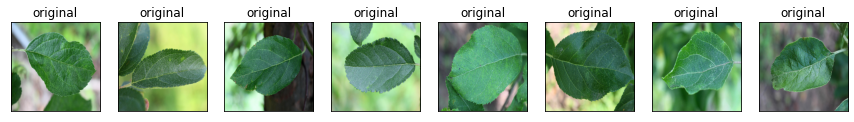

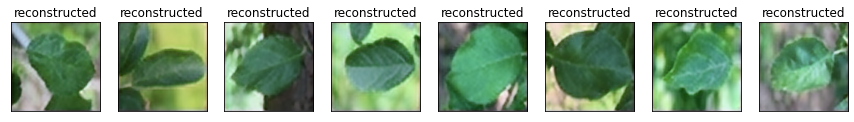

In [17]:
# Lets see how our model reconstructs unseen healthy leaf test dataset but this is still not anomaly
reconstructed = autoencoder.predict(healthy_testdata)
show_data(healthy_testdata, title="original")
show_data(reconstructed, title="reconstructed")

In [14]:
results = autoencoder.evaluate(healthy_testdata, healthy_testdata, batch_size=2)
print("Healthy test loss and accuracy", results)

15/15 [==============================] - 0s 19ms/step - loss: 184.8835 - accuracy: 0.9065
Healthy test loss and accuracy [184.883544921875, 0.9064503908157349]


### Anomaly Prediction and Reconstruction

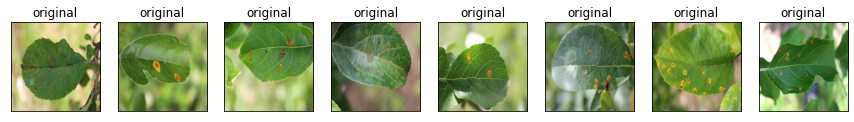

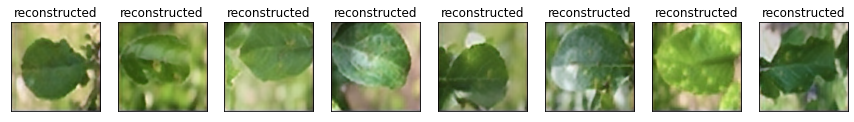

In [15]:
# Lets see how our model reconstructs anomaly disease leaf test dataset
reconstructed = autoencoder.predict(disease_testdata)
show_data(disease_testdata, title="original")
show_data(reconstructed, title="reconstructed")

In [16]:
results = autoencoder.evaluate(disease_testdata, disease_testdata, batch_size=1)
print("Disease test loss and accuracy", results)

17/17 [==============================] - 0s 14ms/step - loss: 211.4502 - accuracy: 0.9089
Disease test loss and accuracy [211.4501953125, 0.9089202880859375]


> Examining the difference between healthy and disease/anomaly test loss, we understand that anomalies/outliers have higher loss value